## Initialization

### Project Description

The supermarket chain Good Seed would like to explore whether Data Science can help them adhere to alcohol laws by making sure they do not sell alcohol to people underage. You are asked to conduct that evaluation, so as you set to work, keep the following in mind:
 - The shops are equipped with cameras in the checkout area which are triggered when a person is buying alcohol
 - Computer vision methods can be used to determine age of a person from a photo
 - The task then is to build and evaluate a model for verifying people's age

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [1]:
import pandas as pd
import numpy as np
import os, sys
from PIL import Image

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
faces = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
faces.shape

(7591, 2)

In [4]:
faces.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
faces.duplicated().sum()

0

In [6]:
faces.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [7]:
faces.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


### Conclusion
 - There are 7,591 faces in the dataset.
 - There are no missing or duplicated values.
 - The average age of a person is 31 with the ages ranging from 1 to 100 years old.

## EDA

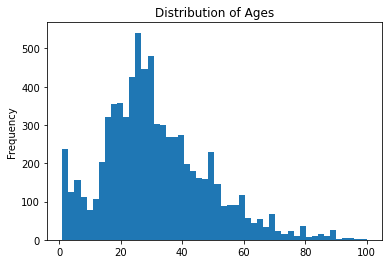

In [8]:
faces['real_age'].plot(kind='hist', title='Distribution of Ages', bins=50)
plt.show()

The distribution is right-skewed with a main peak between 25 and 30.

In [10]:
def plot_images(df, path, num=10, is_generator=False, img_datagen=None):
    """
    Plot a series of images
    """
    plt.figure(figsize=(10, 10))
    if not is_generator:
        sample_faces = df['file_name'].sample(n=num)
    else:
        sample_faces, _ = img_datagen
        sample_faces = sample_faces[:num]
    for idx, file in enumerate(sample_faces):
        plt.subplot(2, 5, idx+1)
        if not is_generator:
            img = Image.open(os.path.join(path, file))
            plt.imshow(np.array(img, dtype=np.uint8))
        else:
            img = file
            plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

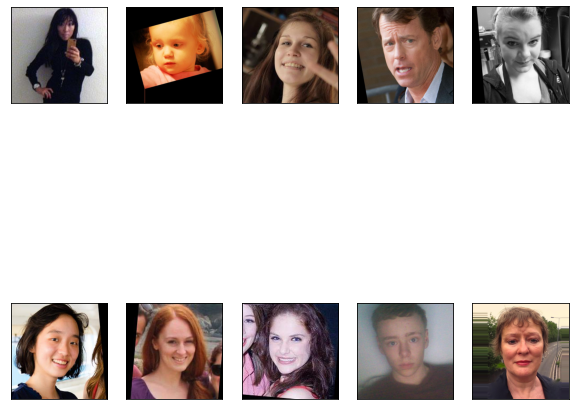

In [11]:
img_dir = r'/datasets/faces/final_files/'
plot_images(faces, img_dir)

### Findings

 - The images are cropped with some being rotated.
 - There are other artifacts noted in thebackground, including poor lighting.

In [12]:
datagen = ImageDataGenerator(rescale=1/255.,
                  horizontal_flip=True,
                  width_shift_range=.2,
                  zoom_range=0.2)
img_datagen = datagen.flow_from_dataframe(faces, 
                            x_col='file_name',
                            y_col='real_age',
                            directory=img_dir,
                            batch_size=32,
                            target_size=(150, 150),
                            class_mode='raw'
                           )
len(img_datagen)

Found 7591 validated image filenames.


238

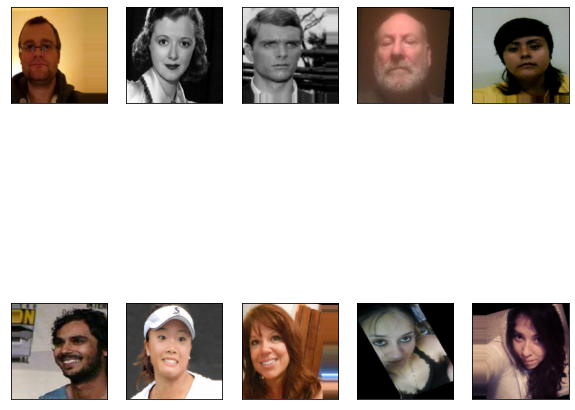

In [13]:
plot_images(faces, img_dir, is_generator=True, img_datagen=next(img_datagen))

There isn't much impact on the resulting images after applying horizontal_flip, width_shift_range and zoom_range augmentation techniques. We'll use this to augment the dataset to avoid overfitting.

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [14]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    df = pd.read_csv(os.path.join(path, 'labels.csv'))
    img_dir = os.path.join(path, 'final_files/')
    
    train_gen = ImageDataGenerator(
                            validation_split=0.2,
                            rescale=1/255.,
                            horizontal_flip=True,
                            width_shift_range=.2,
    )
    train_gen_flow = train_gen.flow_from_dataframe(
                            df,
                            directory=img_dir,
                            x_col='file_name',
                            y_col='real_age',
                            target_size=(150, 150),
                            batch_size=16,
                            class_mode='raw',
                            subset='training',
                            seed=42,
                            )

    return train_gen_flow

In [15]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    df = pd.read_csv(os.path.join(path, 'labels.csv'))
    img_dir = os.path.join(path, 'final_files/')
    
    test_gen = ImageDataGenerator(
                            validation_split=0.2,
                            rescale=1/255.,
    )
    test_gen_flow = test_gen.flow_from_dataframe(
                            df,
                            directory=img_dir,
                            x_col='file_name',
                            y_col='real_age',
                            target_size=(150, 150),
                            batch_size=16,
                            class_mode='raw',
                            subset='validation',
                            seed=42,
                            )

    return test_gen_flow

In [16]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    # model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=1, activation='relu'))
    optimizer = Adam(lr=0.00002)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    return model

In [17]:
def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        shuffle=True,
    )

    return model

## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [ ]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

## Conclusions

With our 20 epochs we were able to achieve a MAE of 5.5504, which is great. The system took less than 30 minutes to run, with each epoch taking just over one minute. This could possibly be further improved by adding dropout, and increasing the training time.

# Checklist

- [ ]  Notebook was opened
- [ ]  The code is error free
- [ ]  The cells with code have been arranged by order of execution
- [ ]  The exploratory data analysis has been performed
- [ ]  The results of the exploratory data analysis are presented in the final notebook
- [ ]  The model's MAE score is not higher than 8
- [ ]  The model training code has been copied to the final notebook
- [ ]  The model training output has been copied to the final notebook
- [ ]  The findings have been provided based on the results of the model training